# ASL Alphabet CNN (PyTorch)

• 80/20 Train–Validation split
• Per-epoch training & validation metrics
• Model saving for deployment

## Imports & Device

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## Dataset & Transform

In [5]:

data_dir = "Asl_alphabet_train/asl1"
img_size = 32
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

full_dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)

print("Total images:", len(full_dataset))
print("Classes:", num_classes)


Total images: 85077
Classes: 29


## 80/20 Split

In [6]:

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Train:", len(train_dataset))
print("Validation:", len(val_dataset))


Train: 68061
Validation: 17016


## CNN Model

In [7]:

class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = CNN(num_classes).to(device)
print(model)


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=29, bias=True)
  )
)


## Training & Validation

In [8]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

def evaluate(loader):
    model.eval()
    loss_sum, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return loss_sum / len(loader), correct / total

for epoch in range(epochs):
    model.train()
    loss_sum, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = loss_sum / len(train_loader)
    train_acc = correct / total
    val_loss, val_acc = evaluate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.4f}")


Epoch [1/10] | Train Loss: 1.067404, Train Acc: 0.6486 | Val Loss: 0.202708, Val Acc: 0.9319
Epoch [2/10] | Train Loss: 0.260839, Train Acc: 0.9069 | Val Loss: 0.100395, Val Acc: 0.9647
Epoch [3/10] | Train Loss: 0.147617, Train Acc: 0.9478 | Val Loss: 0.034755, Val Acc: 0.9891
Epoch [4/10] | Train Loss: 0.103284, Train Acc: 0.9637 | Val Loss: 0.028538, Val Acc: 0.9904
Epoch [5/10] | Train Loss: 0.080435, Train Acc: 0.9723 | Val Loss: 0.019728, Val Acc: 0.9931
Epoch [6/10] | Train Loss: 0.064178, Train Acc: 0.9779 | Val Loss: 0.007842, Val Acc: 0.9979
Epoch [7/10] | Train Loss: 0.055260, Train Acc: 0.9815 | Val Loss: 0.008048, Val Acc: 0.9975
Epoch [8/10] | Train Loss: 0.049011, Train Acc: 0.9843 | Val Loss: 0.004975, Val Acc: 0.9984
Epoch [9/10] | Train Loss: 0.043886, Train Acc: 0.9855 | Val Loss: 0.007099, Val Acc: 0.9974
Epoch [10/10] | Train Loss: 0.042833, Train Acc: 0.9864 | Val Loss: 0.011346, Val Acc: 0.9956


## Curves

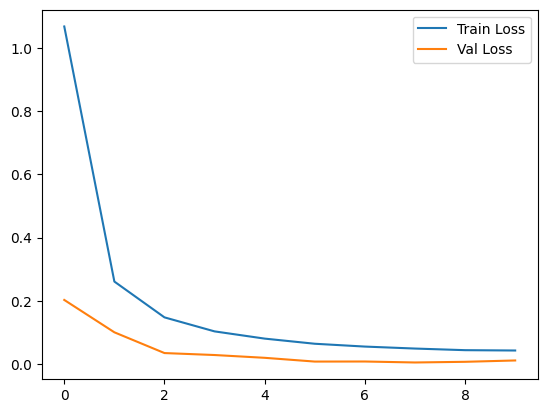

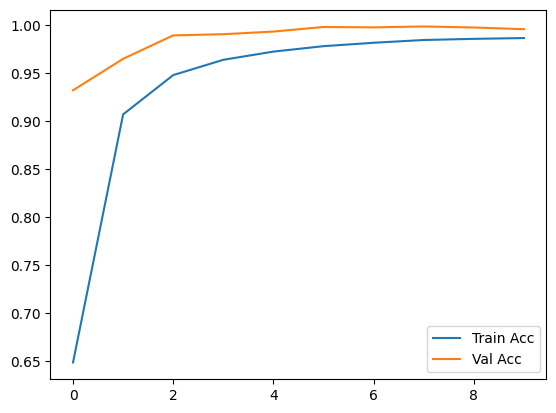

In [9]:

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.show()


## Save Model

In [10]:

torch.save(model.state_dict(), "asl_cnn_model.pth")
print("Saved asl_cnn_model.pth")


Saved asl_cnn_model.pth
